In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('pastel')

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [157]:
import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dropout,Dense,LSTM
from keras.layers.embeddings import Embedding

[nltk_data] Downloading package wordnet to /Users/xue/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df=pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = "ISO-8859-1",header=None)

In [5]:
df.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [6]:
df=df.iloc[:,[0,5]]

In [7]:
df.columns=['label','text']

In [8]:
df.head(10)

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [9]:
df.shape

(1600000, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
label    1600000 non-null int64
text     1600000 non-null object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [11]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [12]:
sum(df['text'].apply(lambda x: type(x)!=str))

0

In [13]:
sum(df['text']=='')

0

### Explore Data

In [14]:
df['label']=df['label'].apply(lambda x: 1 if x>0 else 0)

In [15]:
df['label'].value_counts()

1    800000
0    800000
Name: label, dtype: int64

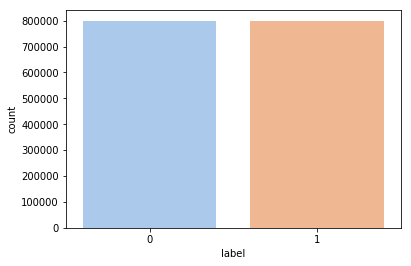

In [16]:
sns.countplot(df['label'])

In [17]:
#replace url
df['text']=df['text'].str.replace(r'((www\.[^\s]+)|(https?://[^\s]+))','')
#replace at_user
df['text']=df['text'].str.replace(r'@[^\s]+','')
#remove #from topic
df['text']=df['text'].str.replace(r'#([^\s]+)', r'\1')
#remove punctuations
df['text']=df['text'].str.replace(r'[-!@#$:).;,?&]', '')
#remove multiple whitespaces
df['text']=df['text'].str.replace(r'[\s]+', ' ')
df['text']=df['text'].str.lower()

0 40


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


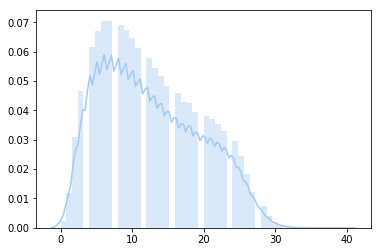

In [19]:
splitted_text=df['text'].str.split()
len_text=[len(list)for list in splitted_text]
print(min(len_text),max(len_text))
sns.distplot(len_text)


In [20]:
df['text']

0           awww that's a bummer you shoulda got david ca...
1          is upset that he can't update his facebook by ...
2           i dived many times for the ball managed to sa...
3            my whole body feels itchy and like its on fire 
4           no it's not behaving at all i'm mad why am i ...
5                                        not the whole crew 
6                                                need a hug 
7           hey long time no see yes rains a bit only a b...
8                                  nope they didn't have it 
9                                              que me muera 
10                  spring break in plain city it's snowing 
11                                 i just repierced my ears 
12          i couldn't bear to watch it and i thought the...
13          it it counts idk why i did either you never t...
14          i would've been the first but i didn't have a...
15          i wish i got to watch it with you i miss you ...
16         hollis' death

In [151]:
import wordcloud
from wordcloud import WordCloud
stop_words = ["AT_USER", "URL"] + list(wordcloud.STOPWORDS)

(-0.5, 799.5, 799.5, -0.5)

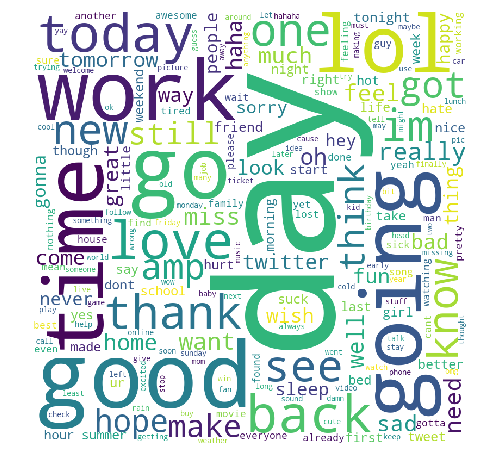

In [152]:
all_reviews=[review for review in df['tokens']]
rand_list=np.random.randint(0,len(all_reviews)-1,3000)
random_3000_reviews=' '.join(all_reviews[i] for i in rand_list)
wordcloud = WordCloud(background_color="white",width=800, height=800, margin=2,stopwords=stop_words).generate(random_3000_reviews)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 799.5, 799.5, -0.5)

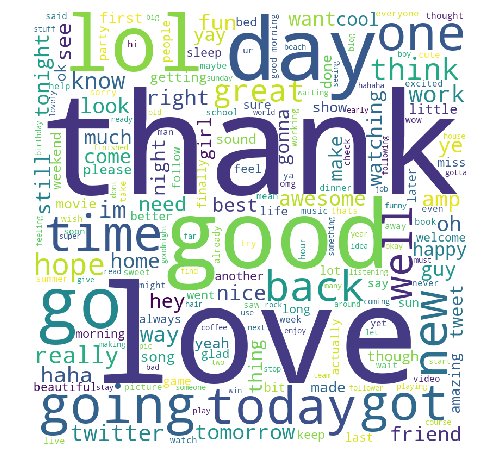

In [154]:
all_pos_reviews=[review for review in df[df['label']==1]['tokens']]
rand_list=np.random.randint(0,len(all_pos_reviews)-1,3000)
random_3000_pos_reviews=' '.join(all_pos_reviews[i] for i in rand_list)
wordcloud = WordCloud(background_color="white",width=800, height=800, margin=2,stopwords=stop_words).generate(random_3000_pos_reviews)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 799.5, 799.5, -0.5)

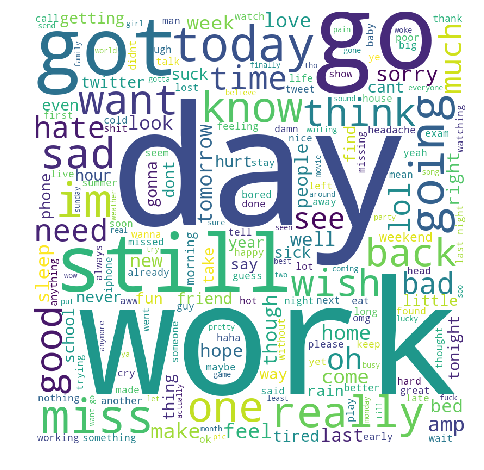

In [153]:
all_neg_reviews=[review for review in df[df['label']==0]['tokens']]
rand_list=np.random.randint(0,len(all_neg_reviews)-1,3000)
random_3000_neg_reviews=' '.join(all_neg_reviews[i] for i in rand_list)
wordcloud = WordCloud(background_color="white",width=800, height=800, margin=2,stopwords=stop_words).generate(random_3000_neg_reviews)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")

### Comments:
1. Generally, people share current moments on twitter by using 'day', 'now', 'today', 'time'. Many of the tweets are about feelings indicated by 'love';
2. In positive tweets, 'love' is the most popular word. People write about funny things with 'lol' and express appreciation through 'thank' and share exploring experience by 'new';
3. A popular topic in negative tweets in 'work' or current work. They also has more 'got', 'go' and 'still'. There are some words directly related to negative feeling such as 'sad' and 'hate'. However, there are positive words like 'love' and 'good'.

### Topic Modeling:


In [140]:
tfidfvector=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')
doc_term_matrix=tfidfvector.fit_transform(df['text'])

In [141]:
nmf=NMF(n_components=2)
nmf.fit(doc_term_matrix)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=2, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [142]:
for topic in nmf.components_:
    print([tfidfvector.get_feature_names()[word_index] for word_index in topic.argsort()[::-1][:15]])

['work', 'just', 'day', 'going', 'today', 'like', 'love', 'know', 'thanks', 'don', 'got', 'really', 'lol', 'time', 'home']
['good', 'morning', 'night', 'luck', 'day', 'hope', 'sounds', 'feeling', 'today', 'feel', 'lost', 'great', 'pretty', 'sleep', 'help']


emotions    1483786
events       116214
Name: topic, dtype: int64


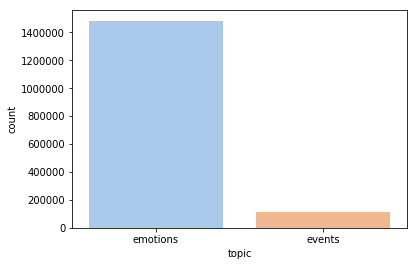

In [143]:
topics_dict={0:'emotions',1:'events'}
df['topic']=nmf.transform(doc_term_matrix).argmax(axis=-1)
df['topic']=df['topic'].map(topics_dict)
print(df['topic'].value_counts())
sns.countplot(df['topic'])

### Comments:
1. The two main topics of the tweets are sharing feelings and logging life events.
2. 60% of the tweets are mainly about what people did and will do such as activities and work.

## VADER Sentiment Analysis:

In [123]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid=SentimentIntensityAnalyzer()

/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [124]:
df['vader_score']=df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


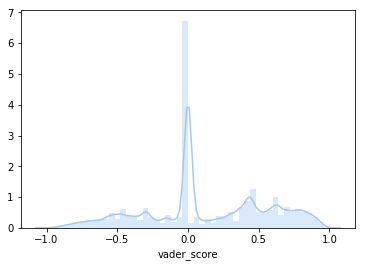

In [125]:
sns.distplot(df['vader_score'])

In [126]:
df['vader_pred']=df['vader_score'].apply(lambda x: 1 if x>0 else 0)

In [127]:
df['vader_pred'].value_counts()

0    846614
1    753386
Name: vader_pred, dtype: int64

In [128]:
print(accuracy_score(df['label'],df['vader_pred']))
print(confusion_matrix(df['label'],df['vader_pred']))
print(classification_report(df['label'],df['vader_pred']))

0.6511525
[[544229 255771]
 [302385 497615]]
              precision    recall  f1-score   support

           0       0.64      0.68      0.66    800000
           1       0.66      0.62      0.64    800000

    accuracy                           0.65   1600000
   macro avg       0.65      0.65      0.65   1600000
weighted avg       0.65      0.65      0.65   1600000



### Comments:
    VADER performs very poor here. The accuracy is 66.7%, not far away from random guessing.
    The reasons can be: 1. people use positive words in negative reviews which is shown in the wordclouds; 
                        2. people use **_sarcasm_** which is hard for VADER to detect. 
    I now explore some positive reviews that receive lowest scores and negative reviews that receive highest scores.

In [129]:
[i for i in df[df['label']==1].sort_values(by=['vader_score'])[:10]['text']]

[' see i didnt even last an hour im backkkk yh i need to vent i hate finance hate hate hate hate hate hate hate hate it',
 'fuck bitches all i do is fuck bitches and after i fuck bitches i be like fuck bitches ',
 ' shit piss fuck cunt cocksucker motherfucker tits fart turd and twat ',
 ' shit piss fuck cunt cocksucker motherfucker tits fart turd and twat blink 182 said it best ',
 'fuck shit fuck fuck fuck cock fuck shit ',
 'holy crap holy crap holy crap holy crap holy crap holy crap holy crap holy crap holy crap holy crap holy crap ',
 'bitches are bitches until they die and whores are whores until they die the end ',
 'fuck fuck fuck fuck fuck fuck fuck ',
 " avian flu killed the birds equine flu killed the horses swine flu is killing pigs can't wait for black flu ",
 ' 7 shit piss fuck cunt cocksucker motherfucker and tits he revised the list later on in life though ']

In [130]:
[i for i in df[df['label']==0].sort_values(by=['vader_score'],ascending=False)[:10]['text']]

['i love you yoo i love you love you love you i love you love you the most i love you i need you amp love you love you eternally i love you',
 'he even donâ´t dance today but we are going to dance tomorrow well iâ´ll need more good luck hehe luck luck luck good luck ',
 ' hey say me something haha now that you in love love love (8 forget about me haha luv ya and im so happy because u happy',
 'working a double but i get to see my best friend yay i love and am so proud of her',
 " i'll be seeing you at the end of august thats too long but i'm excited your going to do great woo take care sweetie xoxo",
 "oh but i have to say e is the best for assigment group love him i wish i can always work with him we'll make a great duo haha",
 'good luck good luck good luck good luck good luck ',
 ' ok i understood yet powering down well i love you i love you i love you i love you venezuela loves bsb ok',
 " i know but it's still the best free twitter iphone app tweetie is the best app period it used

## Classification- Machine Learning Methods
#### Logistic Regression
#### Naive Bayes
#### Support Vector Machine

In [144]:
X=df['text']
y=df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tfidfvector_train=tfidfvector.fit_transform(X_train)
tfidfvector_test=tfidfvector.transform(X_test)

### Logistic Regression

In [145]:
logistic=LogisticRegression()
logistic.fit(tfidfvector_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [146]:
ypred=logistic.predict(tfidfvector_test)
print(accuracy_score(y_test,ypred))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.776565625
[[120363  39131]
 [ 32368 128138]]
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           1       0.77      0.80      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



### Support Vector Machine

In [147]:
scv_clf=LinearSVC()
scv_clf.fit(tfidfvector_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [148]:
y_pred=scv_clf.predict(tfidfvector_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.769565625
[[119466  40028]
 [ 33711 126795]]
              precision    recall  f1-score   support

           0       0.78      0.75      0.76    159494
           1       0.76      0.79      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



### Naive Bayes

In [149]:
naive_bayes_clf=MultinomialNB()
naive_bayes_clf.fit(tfidfvector_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [150]:
y_pred=naive_bayes_clf.predict(tfidfvector_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7604375
[[122661  36833]
 [ 39827 120679]]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76    159494
           1       0.77      0.75      0.76    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



#### comments:
Applying logistic regression, support vector machine and naive bayes to the features, I get accuracy around 77%, much higher than random guessing and VADER sentiment analysis. However, the prediction is still not good enough.

## Classification- Deep Learning Methods
#### Embeddings
#### Convolutional Neural Network
#### Reccurent Neural Network: LSTM

### Embeddings

In [164]:
#tokenize text
tknzr = TweetTokenizer()
df['tokens']=df['text'].apply(lambda x: tknzr.tokenize(x))
#remove stopwords
stopWords = set(stopwords.words('english'))
df['tokens'] = df['tokens'].map(lambda x: [token for token in x if token.isalpha()])
df['tokens']=df['tokens'].apply(lambda x: [token for token in x if not token in stopWords])
#lemmatize text
lemmatizer = WordNetLemmatizer()
df['tokens']=df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

In [165]:
all_token_tweets=[tweet for tweet in df['tokens']]
wv_model = gensim.models.Word2Vec(all_token_tweets,size=300,window=10,min_count=2,workers=10,iter=10)

In [166]:
wv_model.save('wv_model.h5')

In [167]:
len(wv_model.wv.vocab.keys())

117445

In [168]:
wv_model.most_similar("happy")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mehppy', 0.43539926409721375),
 ('unhappy', 0.41574859619140625),
 ('celebrating', 0.4141595959663391),
 ('happier', 0.40208253264427185),
 ('bash', 0.39624398946762085),
 ('proud', 0.3915780186653137),
 ('celebrated', 0.3878910541534424),
 ('happiest', 0.3839017152786255),
 ('celebration', 0.38352832198143005),
 ('yeahhappy', 0.38327234983444214)]

In [169]:
df['tokens']=df['tokens'].apply(lambda x: ' '.join(x))
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(df['tokens'])

In [170]:
df['tokens_int'] = tokenizer.texts_to_sequences(df['tokens'])
df['len_tokens_int']=df['tokens_int'].apply(lambda x: len(x))

In [171]:
token_dict=tokenizer.word_index
vocabulary_size=len(token_dict)
vocabulary_size

377783

In [172]:
#pad the input matrix
X=pad_sequences(df['tokens_int'],maxlen=50,padding='post', truncating='post', value=0.0)
y=df['label']

In [173]:
X.shape

(1600000, 50)

In [174]:
np.savetxt("X.csv", X, delimiter=",")
df['label'].to_csv('y.csv')

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
embedding_matrix=np.zeros((vocabulary_size+1,300))
for word,ind in token_dict.items():
    if word in wv_model.wv:
        embedding_matrix[ind]=wv_model.wv[word]
embedding_matrix.shape    


(377784, 300)

### Convolutional Neural Network

In [74]:
cnn_model=Sequential()
cnn_model.add(Embedding(vocabulary_size+1,300,weights=[embedding_matrix],input_length=50, trainable=False))
cnn_model.add(Conv1D(filters=300,kernel_size=5,padding='valid',activation='relu',strides=1))
cnn_model.add(MaxPooling1D(3))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(filters=200,kernel_size=3,padding='valid',activation='relu',strides=1))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 300)           113335200 
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 46, 300)           450300    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 300)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 300)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 13, 200)           180200    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 200)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
__________

In [75]:
cnn_model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [76]:
history=cnn_model.fit(X_train, y_train,batch_size=1024,epochs=6,validation_split=0.1,verbose=1)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/6
1152000/1152000 [==============================] - 3578s 3ms/step - loss: 0.4982 - acc: 0.7551 - val_loss: 0.4773 - val_acc: 0.7722
Epoch 2/6
1152000/1152000 [==============================] - 3558s 3ms/step - loss: 0.4674 - acc: 0.7755 - val_loss: 0.4649 - val_acc: 0.7786
Epoch 3/6
1152000/1152000 [==============================] - 3556s 3ms/step - loss: 0.4558 - acc: 0.7827 - val_loss: 0.4610 - val_acc: 0.7818
Epoch 4/6
1152000/1152000 [==============================] - 3558s 3ms/step - loss: 0.4474 - acc: 0.7878 - val_loss: 0.4574 - val_acc: 0.7832
Epoch 5/6
1152000/1152000 [==============================] - 3556s 3ms/step - loss: 0.4395 - acc: 0.7923 - val_loss: 0.4536 - val_acc: 0.7846
Epoch 6/6
1152000/1152000 [==============================] - 3561s 3ms/step - loss: 0.4327 - acc: 0.7966 - val_loss: 0.4536 - val_acc: 0.7840


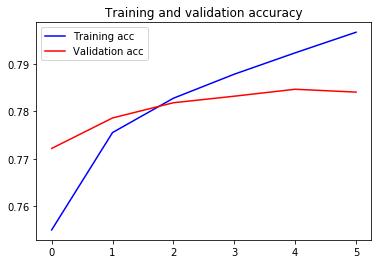

In [77]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

In [79]:
score = cnn_model.evaluate(X_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 386s 1ms/step

ACCURACY: 0.784540625
LOSS: 0.4526227571964264


In [87]:
y_pred=cnn_model.predict(X_test)

In [101]:
ypred=[]
for i in y_pred:
    if i[0]>=0.5:
        ypred.append(1)
    else:
        ypred.append(0)

In [105]:
print(accuracy_score(y_test,ypred))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.78454375
[[123544  35950]
 [ 32996 127510]]
              precision    recall  f1-score   support

           0       0.79      0.77      0.78    159494
           1       0.78      0.79      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [110]:
my_test='I love hanging out with friends!'
my_test=pad_sequences(tokenizer.texts_to_sequences([my_test]), maxlen=50,padding='post', truncating='post', value=0.0)

In [111]:
cnn_model.predict(my_test)

array([[0.8669593]], dtype=float32)

In [122]:
cnn_model.save('cnn_model.h5')

### Reccurent Neural Network: LSTM

In [180]:
lstm_model=Sequential()
lstm_model.add(Embedding(vocabulary_size+1,300,weights=[embedding_matrix],input_length=50, trainable=False, dropout = 0.2))
lstm_model.add(LSTM(200,dropout= 0.2,recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.summary()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 300)           113335200 
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 113,736,201
Trainable params: 401,001
Non-trainable params: 113,335,200
_________________________________________________________________


In [181]:
lstm_model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [182]:
history2=lstm_model.fit(X_train, y_train,batch_size=1024,epochs=6,validation_split=0.1,verbose=1)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/6
1152000/1152000 [==============================] - 3146s 3ms/step - loss: 0.5015 - acc: 0.7536 - val_loss: 0.4644 - val_acc: 0.7780
Epoch 2/6
1152000/1152000 [==============================] - 2955s 3ms/step - loss: 0.4862 - acc: 0.7639 - val_loss: 0.4717 - val_acc: 0.7744
Epoch 3/6
1152000/1152000 [==============================] - 2959s 3ms/step - loss: 0.4722 - acc: 0.7723 - val_loss: 0.4602 - val_acc: 0.7804
Epoch 4/6
1152000/1152000 [==============================] - 2993s 3ms/step - loss: 0.4630 - acc: 0.7781 - val_loss: 0.4541 - val_acc: 0.7830
Epoch 5/6
1152000/1152000 [==============================] - 3013s 3ms/step - loss: 0.4562 - acc: 0.7822 - val_loss: 0.4497 - val_acc: 0.7864
Epoch 6/6
1152000/1152000 [==============================] - 3010s 3ms/step - loss: 0.4505 - acc: 0.7858 - val_loss: 0.4469 - val_acc: 0.7874


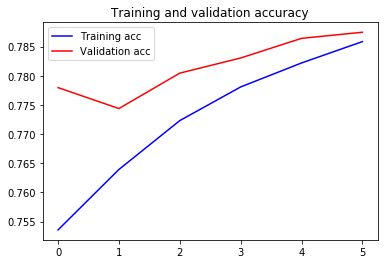

In [183]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

In [184]:
score = lstm_model.evaluate(X_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 326s 1ms/step

ACCURACY: 0.788540625
LOSS: 0.4457007850646973


In [185]:
y_pred=lstm_model.predict(X_test)
ypred=[]
for i in y_pred:
    if i[0]>=0.5:
        ypred.append(1)
    else:
        ypred.append(0)

In [186]:
print(accuracy_score(y_test,ypred))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.788540625
[[122426  37068]
 [ 30599 129907]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.78    159494
           1       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [187]:
lstm_model.predict(my_test)

array([[0.9542531]], dtype=float32)

In [188]:
lstm_model.save('lstm_model.h5')